In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

# Dataset, binary data and continuous data

In [0]:
def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bits.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bits to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

In [0]:
def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

In [0]:
def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

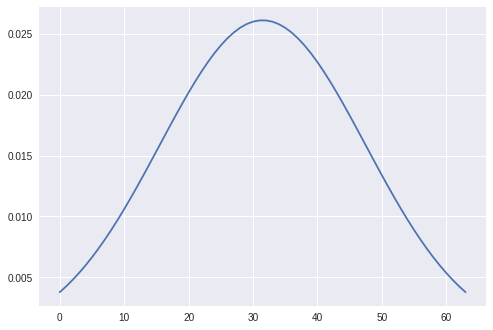

In [28]:
geometry = (6,)
pl1 = gaussian_pdf(geometry, mu=2**5-0.5, sigma=2**4)
plt.plot(pl1)
plt.show()

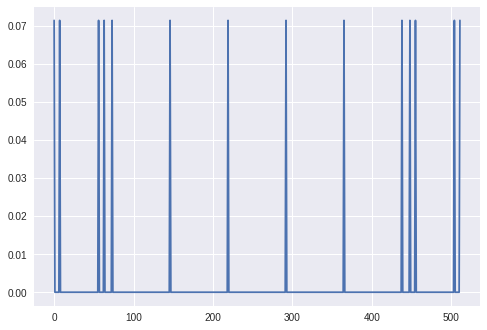

In [29]:
geometry = (3,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)
plt.show()

# Build Circuits
## Building Blocks

In [0]:
######  Pauli Matrices  ########

I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

p0 = (sz + I2) / 2
p1 = (-sz + I2) / 2
h = (sx + sz) / np.sqrt(2.)
sxyz = [I2, sx, sy, sz]

# single bit rotation matrices

def _ri(si, theta):
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rx(theta):
    return _ri(sx, theta)

def ry(theta):
    return _ri(sy, theta)

def rz(theta):
    return _ri(sz, theta)

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return rz(t3).dot(rx(t2)).dot(rz(t1))

# multiple bit construction

def CNOT(ibit, jbit, n):
    res = _([p0, I2], [ibit, jbit], n)
    res = res + _([p1, sx], [ibit, jbit], n)
    return res

def _(ops, locs, n):
    '''
    Put operators in a circuit and compile them.

    notice the big end are high loc bits!

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return _wrap_identity([ops[i] for i in order], np.diff(locs) - 1)


def _wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res

def initial_wf(num_bit):
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

In [0]:
class ArbitraryRotation(object):
    def __init__(self, num_bit):
        self.num_bit = num_bit
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    def __str__(self):
        return 'Rotate[%d]'%(self.num_param)

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [_([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res

class CNOTEntangler(object):
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    def __str__(self):
        pair_str = ','.join(['%d-%d'%(i,j) for i,j in self.pairs])
        return 'CNOT(%s)'%(pair_str)

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

In [0]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        np.testing.assert_(len(theta_list)==0)
        
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

    def __str__(self):
        return '\n'.join([str(b) for b in self])

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrix update method.
    
    Args:
        layer (ArbitraryRotation): rotatio layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]

    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    
    new = old[:]
    new[isite] = _(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new
    
def get_demo_circuit(num_bit, depth, pairs):
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [0]:
def get_nn_pairs(geometry):
    '''define pairs that cnot gates will apply.'''
    num_bit = np.prod(geometry)
    if len(geometry) == 2:
        nrow, ncol = geometry
        res = []
        for ij in range(num_bit):
            i, j = ij // ncol, ij % ncol
            res.extend([(ij, i_ * ncol + j_)
                        for i_, j_ in [((i + 1) % nrow, j), (i, (j + 1) % ncol)]])
        return res
    elif len(geometry) == 1:
        res = []
        for inth in range(2):
            for i in range(inth, num_bit, 2):
                res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
        return res
    else:
       raise NotImplementedError('')

In [19]:
depth = 2
geometry = (6,)

num_bit = np.prod(geometry)
pairs = get_nn_pairs(geometry)
circuit = get_demo_circuit(num_bit, depth, pairs)
print(circuit)

Rotate[12]
CNOT(0-1,2-3,4-5,1-2,3-4,5-0)
Rotate[18]
CNOT(0-1,2-3,4-5,1-2,3-4,5-0)
Rotate[12]


In [20]:
theta_list = np.zeros(circuit.num_param)
theta_list[1] = np.pi
wf = initial_wf(num_bit)
circuit(wf, theta_list)

print(wf)

[6.123234e-17-1.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j

# Build The Gradient training framework for Born Machine

In [0]:
class QCBM(object):
    '''
    Quantum Circuit Born Machine,

    Args:
        circuit (BlockQueue): the circuit architechture.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''get probability distribution function'''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2
        # introducing sampling error
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl), False)
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self.pdf(theta_list)
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x from probability.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim, packbits):
    '''
    emperical probability from data.
    '''
    if packbits:
        dataset = packnbits(dataset).ravel()
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

# MMD Loss Function

In [0]:
class RBFMMD2(object):
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float, loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K).dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

In [0]:
def load_gaussian(num_bit, depth, batch_size=None):
    '''gaussian distribution.'''
    geometry = (num_bit,)
    hndim = 2**num_bit

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_demo_circuit(num_bit, depth, pairs)

    # bar and stripe
    p_bs = gaussian_pdf(geometry, mu=hndim/2., sigma=hndim/4.)

    # mmd loss
    mmd = RBFMMD2(sigma_list=[0.25,4], basis=digit_basis(geometry))

    # Born Machine
    bm = QCBM(circuit, mmd, p_bs, batch_size=batch_size)
    return bm

In [30]:
depth = 2
np.random.seed(2)

bm = load_gaussian(6, depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

print(bm.mmd_loss(theta_list))

0.07670951611610378


In [31]:
g1 = bm.gradient(theta_list)
print(g1)
g2 = bm.gradient_numerical(theta_list)
print(g2)

[ 1.17952416e-02 -1.42216569e-03 -1.57348927e-02  9.03335185e-04
  5.75288126e-03  1.63142734e-02 -7.12182644e-02 -3.68642090e-02
  3.02588251e-03 -2.40086989e-02  1.50153448e-02 -3.09909222e-02
  1.69429572e-03 -1.29632362e-03 -1.85014963e-03  2.20491335e-03
 -1.30370604e-02  1.74039759e-03  1.32711560e-02 -1.88914214e-02
  1.10258254e-02  2.88352582e-02  1.93196284e-02 -2.23607054e-02
  6.43114454e-03  1.15357357e-02  2.04753407e-02 -1.78919374e-03
 -2.71007644e-03  3.35225272e-03 -2.76979957e-03  4.51410813e-03
 -7.87033251e-05  8.99984440e-03  1.60975231e-03  2.38322549e-02
  9.98124714e-03  1.31375606e-02 -1.66375717e-02  9.97649979e-03
 -1.72994602e-07 -5.77337014e-03]
[ 1.17950049e-02 -1.42215591e-03 -1.57346379e-02  9.03324695e-04
  5.75278744e-03  1.63141851e-02 -7.12172915e-02 -3.68638760e-02
  3.02566786e-03 -2.40086199e-02  1.50151627e-02 -3.09906987e-02
  1.69429119e-03 -1.29634099e-03 -1.85014346e-03  2.20489785e-03
 -1.30369463e-02  1.74037488e-03  1.32710938e-02 -1.8891

# Different Training Strategies

In [0]:
from scipy.optimize import OptimizeResult

def spsa(fun, x0,  args=(), bounds=None, ac=(0.2, 0.5), alpha=0.602,
         A=None, gamma=0.101, maxiter=5000, callback=None):
    '''
    simultaneous perturbation stochastic approximation.
    
    Spall, J. C. (1998).
    Implementation of the simultaneous perturbation algorithm for stochastic optimization.
    IEEE Transactions on Aerospace and Electronic Systems.
    https://doi.org/10.1109/7.705889

    Args:
        fun (func): loss function.
        x0 (ndarray): initial variables.
        args (tuple, default=()): additional input parameters for func.
        bounds (tuple|None, default=None): lower bound and higher bound for variables, None for no bounds.
        ac (tuple, default=(0.2,0.5)): initial learning rate and initial perturbation stength.
        A (number, default=0.1*maxiter): statbility constant.
        alpha (float, default=0.602): decay rate for learning speed.
        gamma (float, default=0.101): decay rate for perturbation strength.
        maxiter (int, default=5000): maximum number of iteration.
        callback (func): func(iiter, x) called after each update, with `iiter` the iteration step and `x` the value of variables.

    Note:
        The choice of parameters,
        * `alpha` and `gamma` have thoretically valid default values 0.602 and 0.101.
        * in hight noise setting, pick smaller `a` and larger `c`.
    '''
    if A is None:
        A = 0.1 * maxiter
    a, c = ac

    p = len(x0)
    for k in range(maxiter):
        ak = a / (k + 1 + A)**alpha
        ck = c / (k + 1)**gamma
        g = _get_g(fun, x0, args, ck, return_hessian=False)
        x0 -= ak * g
        if bounds is not None:
            np.clip(x0, *bounds, out=x0)
        if callback is not None:
            callback(x0)
    return OptimizeResult(x=x0, fun=fun(x0, *args), success=True)

def _get_g(fun, x0, args, ck, return_hessian):
    '''calculate gradient'''
    p = len(x0)
    delta = (2 * np.random.randint(0, 2, p) - 1) * ck
    xpos, xneg = x0 + delta, x0 - delta
    fpos, fneg = fun(xpos, *args), fun(xneg, *args)
    g = (fpos - fneg) / (2 * delta)
    if return_hessian:
        delta1 = (2 * np.random.randint(0, 2, p) - 1) * ck
        fneg_ = fun(xneg + delta1, *args)
        fpos_ = fun(xpos + delta1, *args)
        g1n = (fneg_ - fneg) / delta1
        g1p = (fpos_ - fpos) / delta1
        hessian = (g1p - g1n) / 4. / delta[:, None]
        hessian += hessian.T
        return g, hessian
    return g

In [0]:
  def train(bm, theta_list, method, max_iter=1000, popsize=50, step_rate=0.1):
    '''train a Born Machine.'''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        if step[0]%(max_iter//50) == 1:
            print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))
        
    theta_list = np.array(theta_list)
    if method == 'SPSA':
        res = spsa(bm.mmd_loss, x0=theta_list,
                       maxiter=max_iter, callback=callback,
                       )
        return res.fun, res.x
    elif method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

step = 1, loss = 0.016427783967487626
step = 2, loss = 0.009272722012251855
step = 3, loss = 0.006452906490342672
step = 4, loss = 0.00371117975014617
step = 5, loss = 0.0026183160665845884
step = 6, loss = 0.001867104588253835
step = 7, loss = 0.0013668029390471585
step = 8, loss = 0.0010577392968785728
step = 9, loss = 0.000762585467783222
step = 10, loss = 0.0005982977764923203
step = 11, loss = 0.0004864317018575236
step = 12, loss = 0.0003878196110034959
step = 13, loss = 0.00034191833510487546
step = 14, loss = 0.0002681024124093896
step = 15, loss = 0.00023903360335532418
step = 16, loss = 0.00019650794567779248
step = 17, loss = 0.00016465406462605323
step = 18, loss = 0.0001331070935064904
step = 19, loss = 0.0001140109099872301
step = 20, loss = 8.298805853868059e-05
step = 21, loss = 7.47338217690642e-05


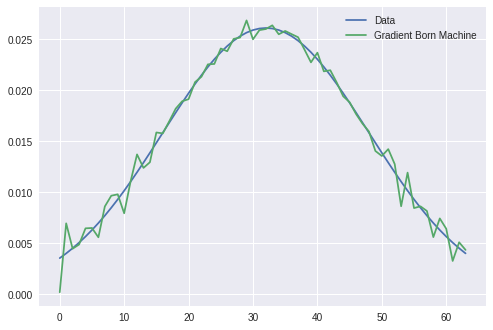

In [26]:
depth = 6
np.random.seed(2)

bm = load_gaussian(6, depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=20)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()

In [0]:
def load_barstripe(geometry, depth):
    '''3 x 3 bar and stripes.'''
    num_bit = np.prod(geometry)

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_demo_circuit(num_bit, depth, pairs)

    # bar and stripe
    p_bs = barstripe_pdf(geometry)

    # mmd loss
    mmd = RBFMMD2(sigma_list=[2.], basis=binary_basis((num_bit,)))

    # Born Machine
    bm = QCBM(circuit, mmd, p_bs)
    return bm

# Training with Noisy Data

Sample size $N=20000$ controls the noises.
We compare training using Adam and SPSA

step = 1, loss = 0.018820856800847195
step = 3, loss = 0.010123188127868658
step = 5, loss = 0.008820370318052547
step = 7, loss = 0.008807999414796529
step = 9, loss = 0.0063043433521419775
step = 11, loss = 0.005894555170176897
step = 13, loss = 0.00439574307615166
step = 15, loss = 0.00410835611138544
step = 17, loss = 0.0043689847772890545
step = 19, loss = 0.003157479915341924
step = 21, loss = 0.0031968643843896622
step = 23, loss = 0.0035172446479268746
step = 25, loss = 0.002795781575362333
step = 27, loss = 0.003058463315395112
step = 29, loss = 0.002275891864493244
step = 31, loss = 0.0026598856286334347
step = 33, loss = 0.002163457146041098
step = 35, loss = 0.001964917413876503
step = 37, loss = 0.0023414673480427533
step = 39, loss = 0.0020460529038371505
step = 41, loss = 0.002127565062213616
step = 43, loss = 0.0017431562708999735
step = 45, loss = 0.0019425703770306396
step = 47, loss = 0.0037177630890477104
step = 49, loss = 0.0017483505306385017
step = 51, loss = 0.0

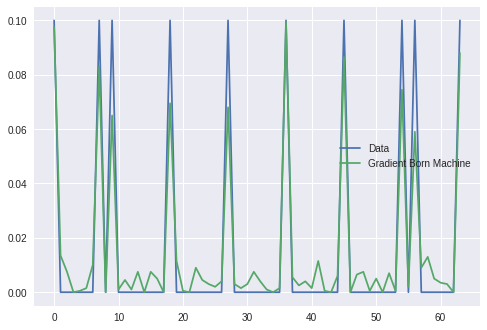

In [44]:
np.random.seed(2)
depth = 4
geometry = (2, 3)

bm = load_barstripe(geometry, depth)
bm.batch_size = 2000
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'Adam', max_iter=100, popsize=10)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()

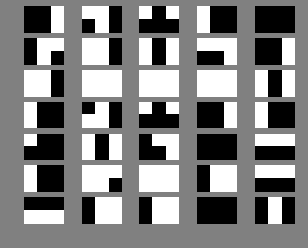

In [45]:
# generate samples
size = (7,5)
pl = bm.pdf(theta_list)
indices = np.random.choice(np.arange(len(pl)), np.prod(size), p=pl)
samples = binary_basis(geometry)[indices]

# show
fig = plt.figure(figsize=(5,4), facecolor='gray')
gs = plt.GridSpec(*size)
for i in range(size[0]):
    for j in range(size[1]):
        plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
        plt.axis('equal')
        plt.axis('off')
plt.show()

In [46]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'SPSA', max_iter=100*bm.circuit.num_param, popsize=10)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine (SPSA)'])
plt.show()

step = 1, loss = 0.014691208563616486
step = 157, loss = 0.014988349456891224
step = 313, loss = 0.014243381672254514


KeyboardInterrupt: ignored

# SPSA not Working?

Lets optimize a problem with 24 parameters

In [49]:
test_func = lambda x: np.cos(x).sum()
max_iter = 2000

step = [0]
def callback(x, *args, **kwargs):
    step[0] += 1
    if step[0]%(max_iter//50) == 1:
        print('step = %d, loss = %s'%(step[0], test_func(x)))
        
res = spsa(test_func, x0=np.random.random(24),
               maxiter=max_iter, callback=callback,
               )

step = 1, loss = 20.796581751465737
step = 41, loss = 17.67989562802431
step = 81, loss = 14.08103567206227
step = 121, loss = 8.745535205647682
step = 161, loss = 4.02103044679887
step = 201, loss = -0.07336469454172878
step = 241, loss = -2.797866790716694
step = 281, loss = -5.78570627582404
step = 321, loss = -8.718937120989885
step = 361, loss = -11.091224065672787
step = 401, loss = -13.055019525299844
step = 441, loss = -14.502209466639925
step = 481, loss = -16.099918437533287
step = 521, loss = -17.25192374217347
step = 561, loss = -18.078309988841006
step = 601, loss = -18.986836301802008
step = 641, loss = -19.573928884899914
step = 681, loss = -20.243853615671508
step = 721, loss = -21.268868044065307
step = 761, loss = -21.74049667232036
step = 801, loss = -22.37825658815569
step = 841, loss = -22.60812656731494
step = 881, loss = -22.882512300222977
step = 921, loss = -23.094404364598198
step = 961, loss = -23.30299976104161
step = 1001, loss = -23.454831268909643
step = 

SPSA is ok, but not for noisy quantum circuits.